## Age and Gender Detection System.

### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [266]:
pip install face_recognition

Note: you may need to restart the kernel to use updated packages.


In [267]:
# Import necessary modules first.
import tensorflow as tf
import cv2
import face_recognition
from tensorflow.keras.utils import load_img 
from keras.models import load_model
from keras.models import Sequential, Model,Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten,Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
from PIL import Image
import pandas as pd
from tqdm import tqdm
import pandas as pd
from zipfile import ZipFile
import time
#the following are to do with this interactive notebook code
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)



In [268]:

# Define the base directory where the images are stored
BASE_DIR = '/Users/khalifa/Desktop/Senior Project/UTKFace-All-Gneder'

# Initialize empty lists to store age labels, gender labels, and image paths
age_labels = []
gender_labels = []
image_paths = []

# List all files in the specified directory
image_filenames = os.listdir(BASE_DIR)

# Shuffle the list of image filenames randomly
random.shuffle(image_filenames)

# Iterate through each image filename using tqdm for progress tracking
for image in tqdm(image_filenames):

    # Check if the file is an image (assuming image files have extensions like .jpg, .png, etc.)
    if image.endswith(('.jpg', '.jpeg', '.png', '.gif')):

        # Create the full path to the image by joining the base directory and filename
        image_path = os.path.join(BASE_DIR, image)

        # Split the filename using '_' as the delimiter to extract age and gender components
        img_components = image.split('_')

        # Ensure that the filename follows the expected naming convention
        if len(img_components) >= 2:
            try:
                # Convert the age and gender components to integers
                age_label = int(img_components[0])
                gender_label = int(img_components[1])

                # Append the image_path, age_label, and gender_label to their respective lists
                age_labels.append(age_label)
                gender_labels.append(gender_label)
                image_paths.append(image_path)
            except ValueError:
                print(f"Ignoring file {image}: Invalid age or gender label format")
        else:
            print(f"Ignoring file {image}: File name does not follow the expected convention")

# Print the number of processed images
print(f"Number of processed images: {len(image_paths)}")


100%|██████████| 23708/23708 [00:00<00:00, 353255.37it/s]

Number of processed images: 23708


In [ ]:
# Define the input shape for the neural network model
input_shape = (128, 128, 1)
inputs = Input(input_shape)

# Convolutional layers with max pooling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

# Flatten the output for fully connected layers
flatten = Flatten()(max_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

# Dropout layers for regularization
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# Output layers for gender and age prediction
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

# Define the model with input and output layers
model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Compile the model
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


In [269]:
# Print the number of elements in the age_labels, gender_labels, and image_paths lists
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')


Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [270]:
# Define a mapping for gender labels:
# Key: 1 represents Female, Key: 0 represents Male
gender_mapping = {
    1: 'Female',
    0: 'Male'
}


In [271]:
# Create a Pandas DataFrame to organize image data
df = pd.DataFrame()

# Populate DataFrame columns with processed data
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

# Display the first 5 rows of the DataFrame
df.head(5)


image_path  age  gender
0  /Users/khalifa/Desktop/Senior Project/UTKFace-...    1       0
1  /Users/khalifa/Desktop/Senior Project/UTKFace-...    1       1
2  /Users/khalifa/Desktop/Senior Project/UTKFace-...   32       0
3  /Users/khalifa/Desktop/Senior Project/UTKFace-...   26       0
4  /Users/khalifa/Desktop/Senior Project/UTKFace-...   38       1

## Exploratory Data Anlysis

<Axes: xlabel='age', ylabel='Density'>

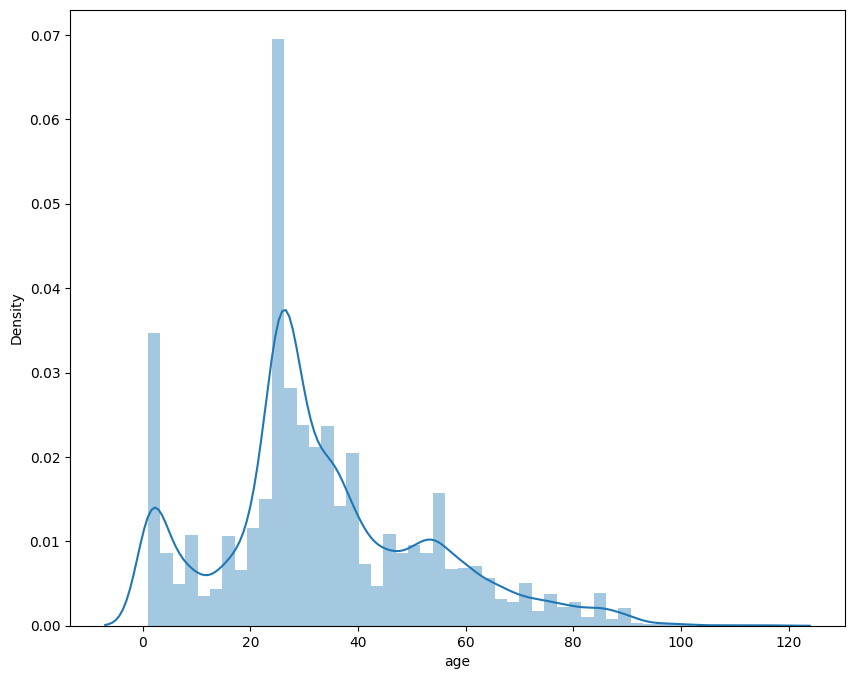

In [272]:
# Create and display a distribution plot of ages using Seaborn
sns.distplot(df['age'])

The distribution roughly follows a normal distribution that is slightly skewed to the right with a median of around 27 years. The range is from 0 to 120 years. There are some outliers at the higher end of the distribution.

<Axes: xlabel='gender', ylabel='Density'>

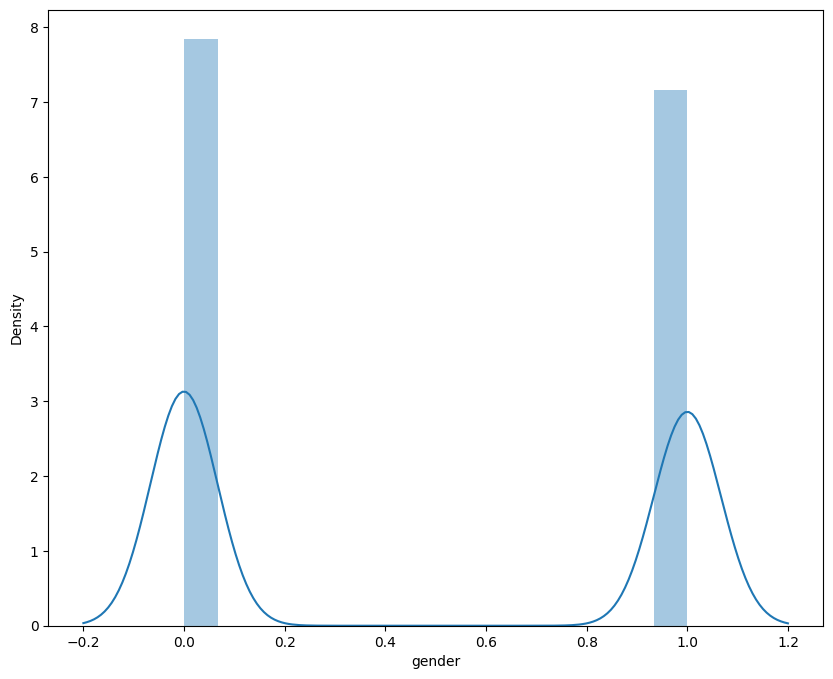

In [273]:
# Create and display a distribution plot of genders using Seaborn
sns.distplot(df['gender'])

In [274]:
gender_counts = df['gender'].value_counts(normalize=True) * 100
print("\nGender distribution (percentage):")
print(gender_counts)


Gender distribution (percentage):
gender
0    52.265058
1    47.734942
Name: proportion, dtype: float64


In [275]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax', name='gender_output'),
    Dense(1, name='age_output')
])

model.compile(optimizer='adam',
              loss={'gender_output': 'categorical_crossentropy', 'age_output': 'mse'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


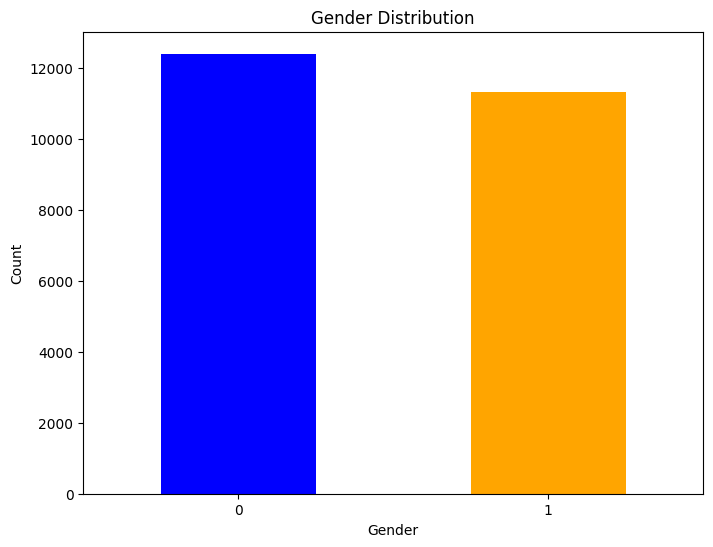

In [276]:
# Plot the gender distribution
plt.figure(figsize=(8, 6))
df['gender'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

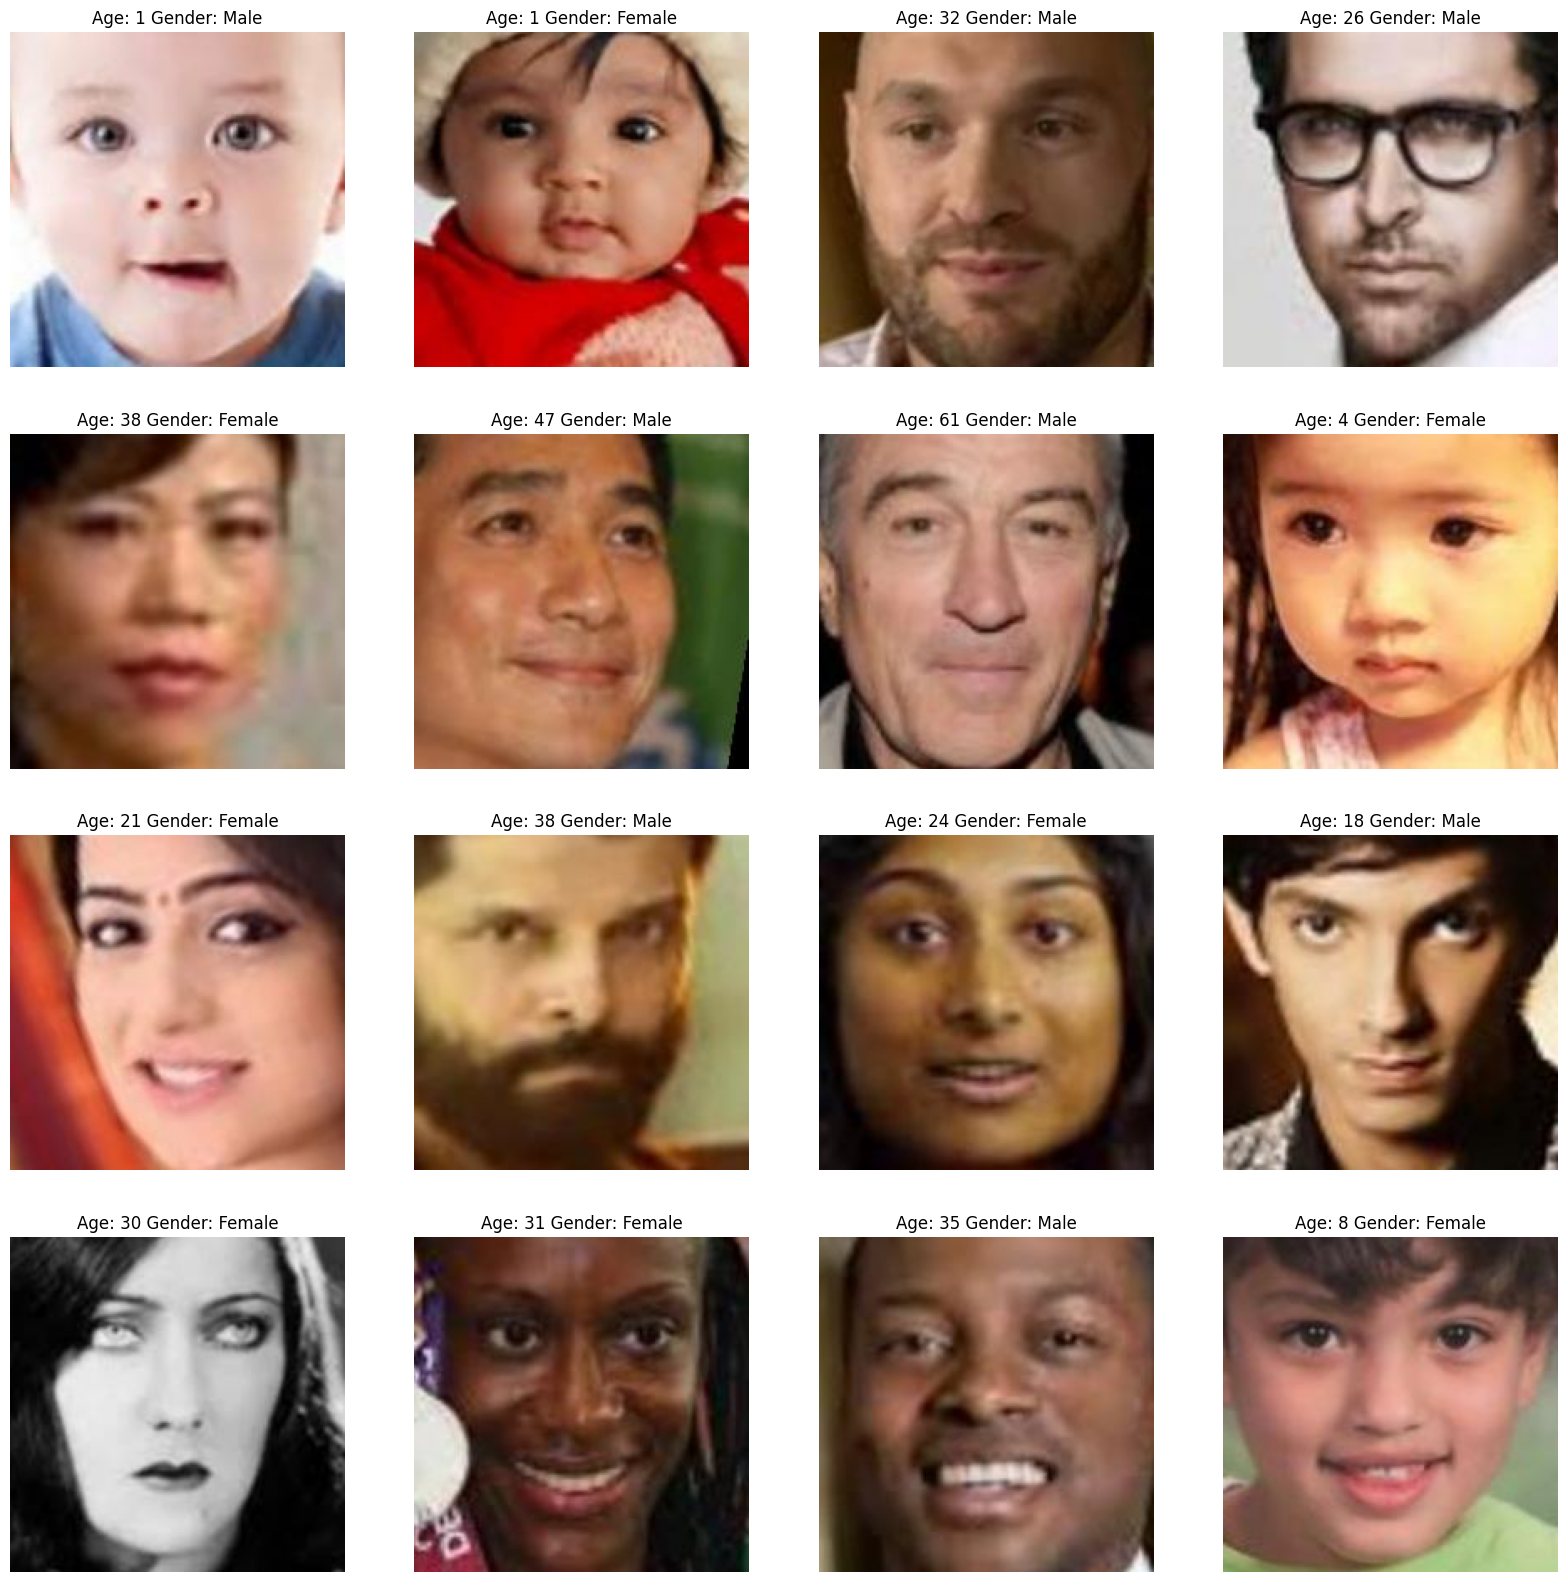

In [277]:
plt.figure(figsize=(20, 20))

# Select a subset of samples from the DataFrame
samples = df.iloc[0:16]

# Iterate over the selected samples and display them in a 4x4 grid
for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)

    # Load and convert the image to a NumPy array
    img = load_img(sample)
    img = np.array(img)

    # Turn off axis labels for cleaner visualization
    plt.axis('off')

    # Set the title with age and gender information
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')

    # Display the image
    plt.imshow(img)


## Feature Extraction

In [278]:
#Extracts image features by loading and preprocessing images
#images list List of image paths
#features numpy.ndarray NumPy array containing the extracted image features
def extract_image_features(images):
    features = list()


     # Iterate over each image path in the provided list
    for image in tqdm(images):
        # Load the image in grayscale mode
        img = load_img(image, grayscale=True)

        # Resize the image to a fixed size of 128x128 pixels with antialiasing
        img = img.resize((128, 128), Image.ANTIALIAS)

        # Convert the image to a NumPy array
        img = np.array(img)

        # Append the preprocessed image to the features list
        features.append(img)

    # Convert the list of features to a NumPy array
    features = np.array(features)

    # Reshape the array to have dimensions (number_of_images, 128, 128, 1)
    features = features.reshape(len(features), 128, 128, 1)

    return features

In [279]:
# Extract image features from the 'image_path' column of the DataFrame
X = extract_image_features(df['image_path'])


  0%|          | 0/23708 [00:00<?, ?it/s]

100%|██████████| 23708/23708 [00:17<00:00, 1355.74it/s]


In [280]:
# Check the shape of the array X (dimensions of the image features)
X.shape

(23708, 128, 128, 1)

In [281]:
# Normalize pixel values in the array X to the range [0, 1]
X = X / 255.0

In [282]:
# Create NumPy arrays for gender and age labels from the DataFrame
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])


In [283]:
# Define the input shape for the neural network model
input_shape = (128, 128, 1)

In [284]:
# Define the input layer with the specified input shape
inputs = Input((input_shape))

# Convolutional layers with max pooling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

# Flatten the output for fully connected layers
flatten = Flatten()(max_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

# Dropout layers for regularization
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# Output layers for gender and age prediction
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

# Define the model with input and output layers
model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Compile the model with specified loss functions, optimizer, and metrics
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])


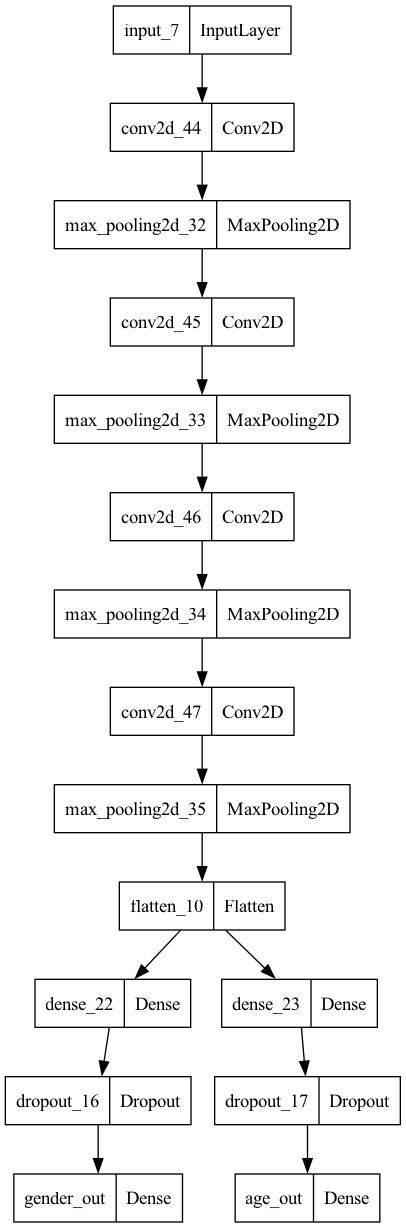

In [285]:
# Import the plot_model function from TensorFlow's Keras utilities
from tensorflow.keras.utils import plot_model

# Generate and display a visualization of the neural network model
plot_model(model)


In [286]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Define the input shape for the neural network model
input_shape = (128, 128, 1)

# Define the input layer with the specified input shape
inputs = Input(shape=input_shape)

# Convolutional layers with max pooling
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

# Flatten the output for fully connected layers
flatten = Flatten()(max_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

# Dropout layers for regularization
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# Output layers for gender and age prediction
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

# Define the model with input and output layers
model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Compile the model with specified loss functions, optimizer, and metrics
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])


In [287]:

def predict_age_and_gender(image_path):

    # Load the image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    face_locations = face_recognition.face_locations(rgb_image)
    print(f"Number of faces detected: {len(face_locations)}")

    # Initialize counters for males and females
    male_count = 0
    female_count = 0

    for face_location in face_locations:
        top, right, bottom, left = face_location

        # Extract the face from the image
        face_image = rgb_image[top:bottom, left:right]

        # Here you would include your model's age and gender prediction
        # For this example, let's use placeholders
        predicted_age = "Unknown"  # Replace with actual age prediction
        predicted_gender = "Unknown"  # Replace with actual gender prediction

        # Example predictions - Replace these with actual model predictions
        # For the purpose of example, let's randomly assign gender
        predicted_gender = random.choice(["Male", "Female"])

        if predicted_gender == "Male":
            male_count += 1
        elif predicted_gender == "Female":
            female_count += 1

        # Draw a rectangle around the face
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

        # Add text labels for age and gender
        cv2.putText(image, f'Age: {predicted_age}', (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.putText(image, f'Gender: {predicted_gender}', (left, bottom + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the counts of males and females
    print(f"Number of males: {male_count}")
    print(f"Number of females: {female_count}")

    # Display the image with annotations
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()



Number of faces detected: 36
Number of males: 23
Number of females: 13


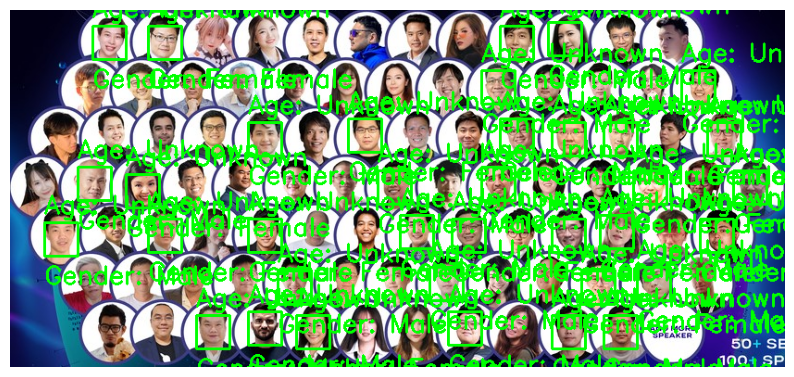

In [288]:
# Test with one of the images from your dataset
test_image_path = '/Users/khalifa/Desktop/Senior Project/images/Poster-All-Speaker_(1) (1).jpg'
predict_age_and_gender(test_image_path)

In [289]:
export_dir='/Users/khalifa/Downloads/Detection/1.1_age_input_output/output/age_model_pretrained.h5'
age_model = load_model(export_dir)

# summarize model.
age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       0

In [290]:
# load and evaluate a saved model
export_dir='/Users/khalifa/Downloads/Detection/1.2_gender_input_output/output/gender_model_pretrained.h5'
gender_model = load_model(export_dir)

# summarize model.
gender_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 70)        700       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 65)        41015     
                                                                 
 batch_normalization (Batch  (None, 96, 96, 65)        260       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 65)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 60)        35160 

In [291]:
export_dir='/Users/khalifa/Downloads/Detection/1.3_emotion_input_output/output/emotion_model_pretrained.h5'
emotion_model = load_model(export_dir)

# summarize model.
emotion_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                             

In [292]:
# Labels on Age, Gender and Emotion to be predicted

age_ranges = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
gender_ranges = ['male', 'female']
emotion_ranges= ['positive','negative','neutral']

In [293]:
# img_path = "./1.4_test_input/images/priyanka_chopra.jpg"
# img_path = "./1.4_test_input/images/kartik_aryan.jpg"
img_path = "/Users/khalifa/Desktop/Senior Project/images/family.jpg"

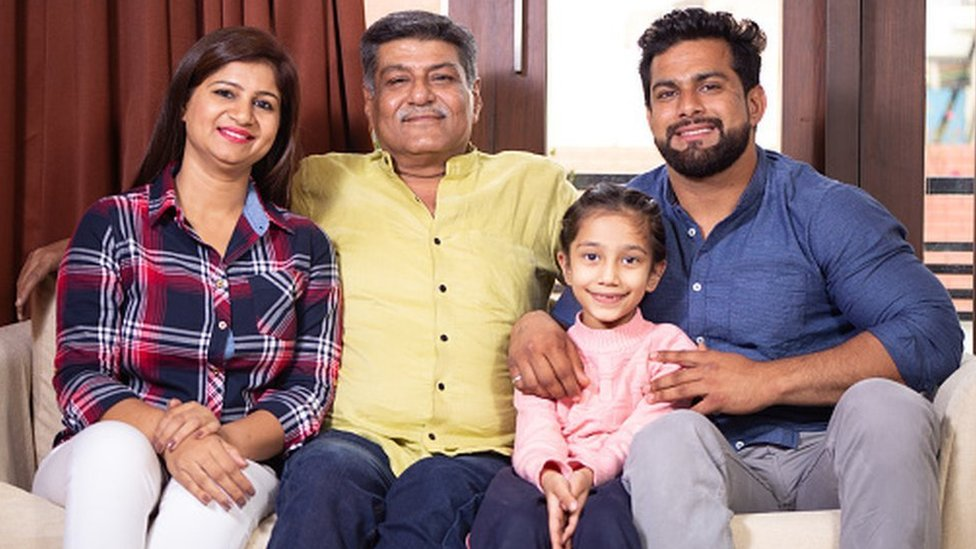

In [294]:
from IPython.display import Image 
pil_img = Image(filename=img_path)
display(pil_img)

1/1 [==============================] - 0s 74ms/step
1: male, 46-65, positive
1/1 [==============================] - 0s 18ms/step
2: male, 28-45, positive
1/1 [==============================] - 0s 18ms/step
3: female, 28-45, positive
1/1 [==============================] - 0s 15ms/step
4: female, 10-20, positive


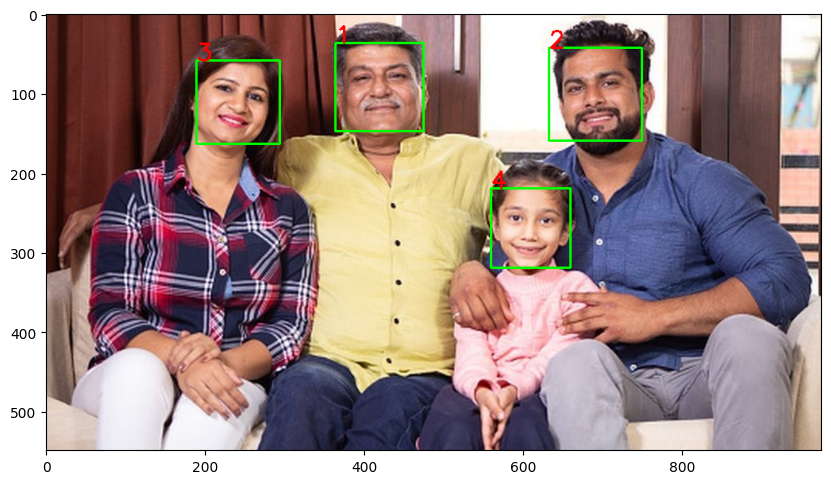

In [295]:
test_image = cv2.imread(img_path)
gray = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('/Users/khalifa/Downloads/Detection/1.4_test_input/cv2_cascade_classifier/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

i = 0

for (x,y,w,h) in faces:
  i = i+1
  cv2.rectangle(test_image,(x,y),(x+w,y+h),(0,255,0),2)

  img_gray=gray[y:y+h,x:x+w]

  emotion_img = cv2.resize(img_gray, (48, 48), interpolation = cv2.INTER_AREA)
  emotion_image_array = np.array(emotion_img)
  emotion_input = np.expand_dims(emotion_image_array, axis=0)
  output_emotion= emotion_ranges[np.argmax(emotion_model.predict(emotion_input))]
  
  gender_img = cv2.resize(img_gray, (100, 100), interpolation = cv2.INTER_AREA)
  gender_image_array = np.array(gender_img)
  gender_input = np.expand_dims(gender_image_array, axis=0)
  output_gender=gender_ranges[np.argmax(gender_model.predict(gender_input))]

  age_image=cv2.resize(img_gray, (200, 200), interpolation = cv2.INTER_AREA)
  age_input = age_image.reshape(-1, 200, 200, 1)
  output_age = age_ranges[np.argmax(age_model.predict(age_input))]


  output_str = str(i) + ": "+  output_gender + ', '+ output_age + ', '+ output_emotion
  print(output_str)
  
  col = (0,0,255)

  cv2.putText(test_image, str(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,col,2)

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))



## Age Detection

In [296]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/Users/khalifa/Desktop/Senior Project/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [297]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/Users/khalifa/Desktop/Senior Project/content/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [298]:
# Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.

train_aug_df = pd.read_csv("/Users/khalifa/Desktop/Senior Project/images_filenames_labels_train_augmented(1).csv")
test_df = pd.read_csv("/Users/khalifa/Desktop/Senior Project/images_filenames_labels_test(1).csv")

In [299]:
train_aug_df.head()
test_df.head()
train_aug_df.shape
test_df.shape

(10046, 2)

## Define Age Classes

In [300]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [301]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [302]:
train_aug_df.head()
test_df.head()

filename  age  target
0  /Users/khalifa/Desktop/Senior Project/content/...    8       1
1  /Users/khalifa/Desktop/Senior Project/content/...   38       4
2  /Users/khalifa/Desktop/Senior Project/content/...   40       4
3  /Users/khalifa/Desktop/Senior Project/content/...   36       4
4  /Users/khalifa/Desktop/Senior Project/content/...    8       1

## Organize Dataset

In [303]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [304]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [305]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [306]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

# CNN Architecture

In [307]:
# Defining the architecture of the sequential neural network.

final_cnn = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_12 (Aver  (None, 99, 99, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_53 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_13 (Aver  (None, 48, 48, 64)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_54 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_14 (Aver  (None, 23, 23, 128)      

In [308]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Define a custom metric for age_accuracy
def age_accuracy(y_true, y_pred):
    # Assuming age is represented as a single class, modify this accordingly if age is a regression target.
    y_true_age = y_true[:, 1]  # Adjust this index based on how your data is structured
    y_pred_age = K.argmax(y_pred, axis=-1)
    accuracy = K.mean(K.equal(y_true_age, y_pred_age))
    return accuracy


In [309]:
# Compiling the above created CNN architecture.

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [310]:
# Creating a TensorBoard callback object and saving it at the desired location.

tensorboard = TensorBoard(log_dir=f"/Users/khalifa/Downloads/Detection/1.1_age_input_output/output/cnn_logs")

In [311]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/Users/khalifa/Downloads/Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Model Fitting

In [313]:
# Train the neural network model on the provided data
# - X: Image features
# - y_gender: Gender labels
# - y_age: Age labels
# The training history is stored in the 'history' variable
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=10, validation_split=0.1)
 

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=5,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    
                                 )

Epoch 1/10
139/667 [=====>........................] - ETA: 2:12 - loss: 16.0019 - gender_out_loss: 0.6925 - age_out_loss: 15.3094 - gender_out_accuracy: 0.5238 - age_out_accuracy: 0.0495

KeyboardInterrupt: 

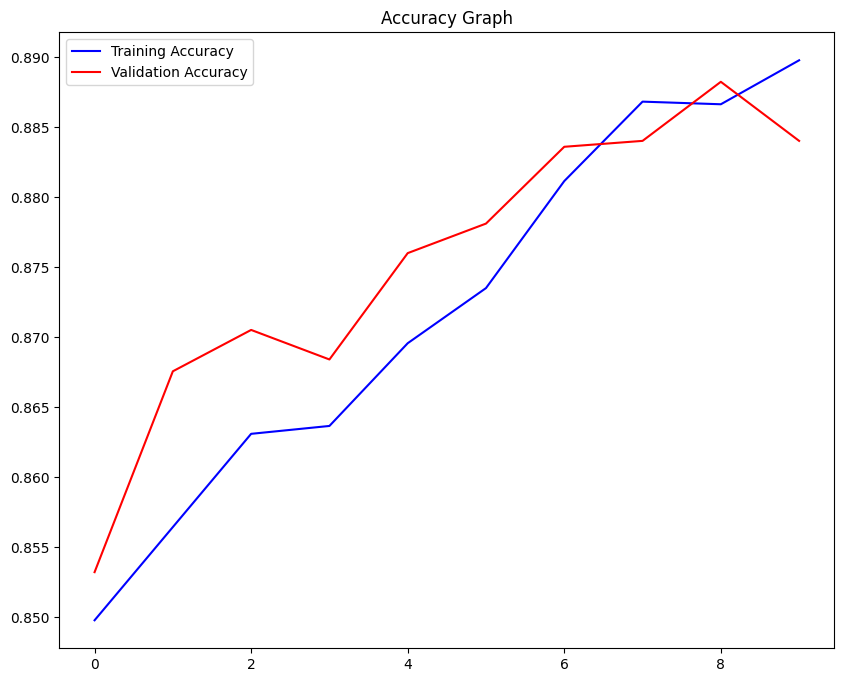

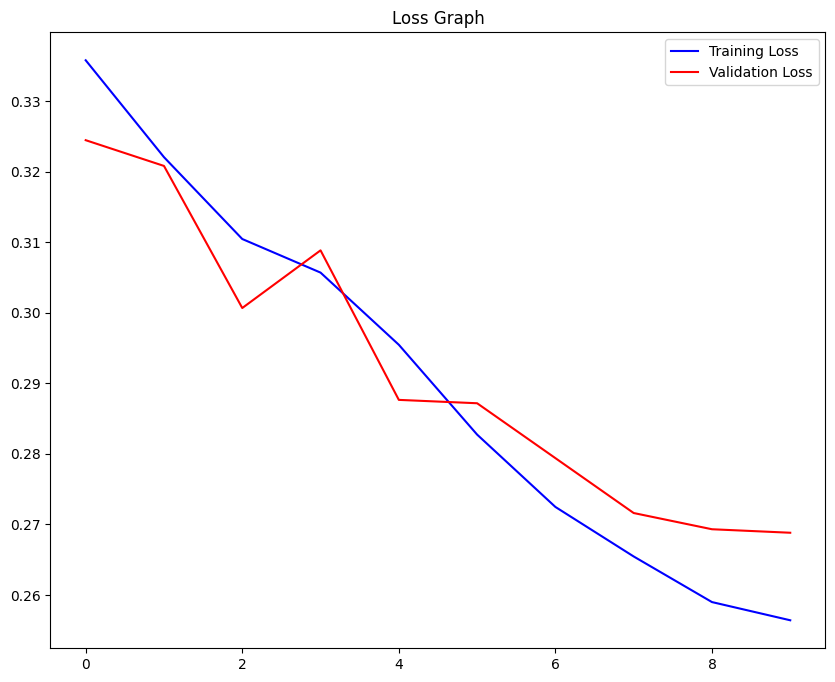

In [ ]:
# Plot and visualize the training and validation results for gender prediction

# Accuracy graph
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Loss graph
loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

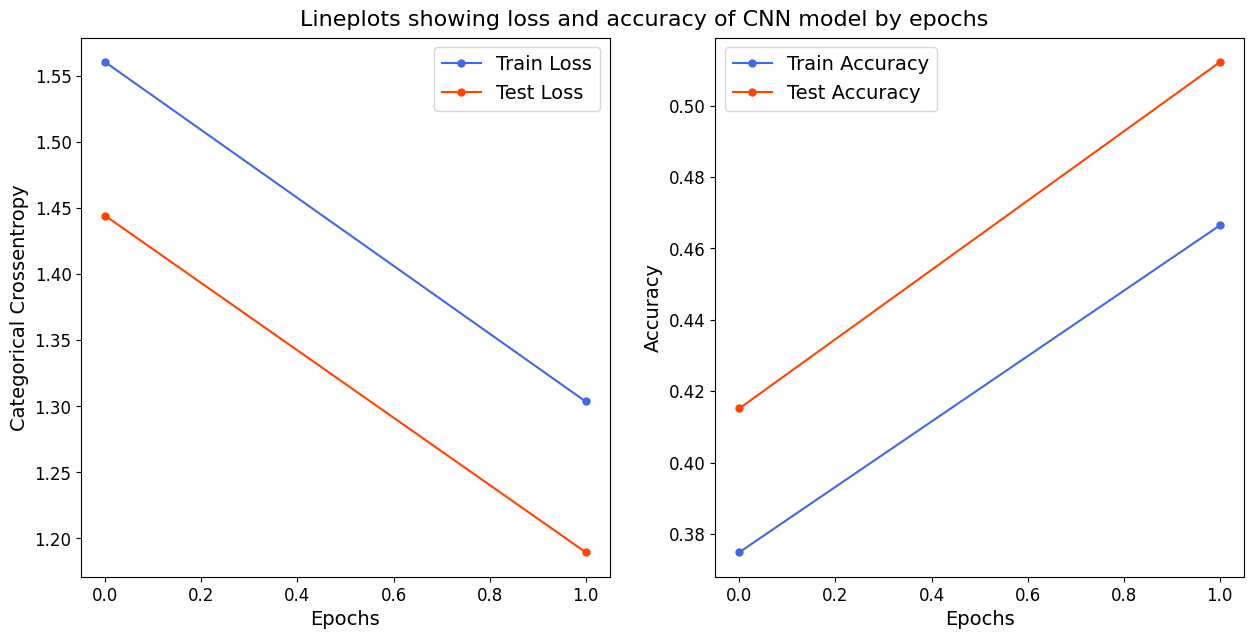

In [ ]:
# Plot and visualize the training and validation results for age prediction

# Loss graph
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/Users/khalifa/Downloads/Detection/1.1_age_input_output/output/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Printing the relevant score summary.

final_cnn_labels = final_cnn.metrics_names
print(f'Age {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'Age {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

Age loss 		= 1.19
Age accuracy 	= 0.512


In [ ]:
final_cnn.save(f"/Users/khalifa/Downloads/Detection/1.1_age_input_output/output/age_model_acc_0.779.h5{round(final_cnn_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

20/20 [==============================] - 60s 3s/step


In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 824,   60,    4,   20,   44,    5,    1],
       [ 175,  269,   53,  123,  198,   21,    6],
       [   7,   78,  158,  200,  450,   46,    2],
       [   7,    8,   17,  751, 1174,   49,    1],
       [   3,    6,    9,  365, 2195,  227,    2],
       [   4,    9,   15,   29,  842,  714,   66],
       [   3,   10,    2,    2,  120,  438,  234]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/Users/khalifa/Downloads/Detection/1.1_age_input_output/output/cnn_logs{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


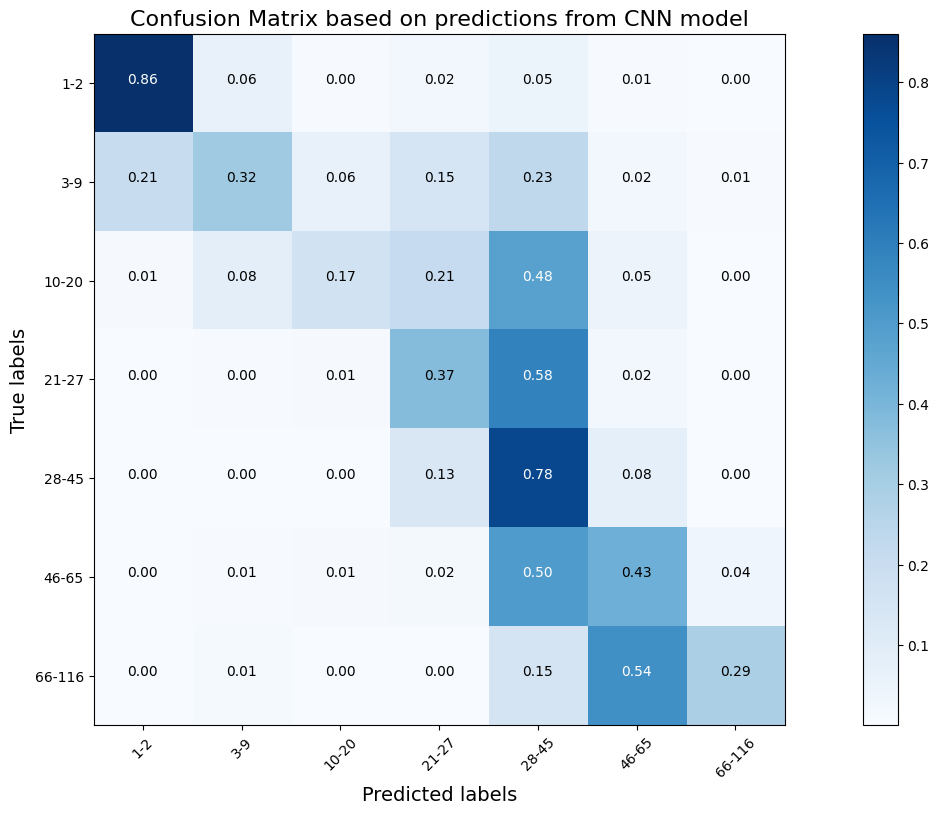

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

## Predicting Test Data

In [ ]:
# Count the number of women (gender = 1)
num_women = df[df['gender'] == 1].shape[0]
print(f"Number of women in the dataset: {num_women}")

# Count the number of men (gender = 0)
num_men = df[df['gender'] == 0].shape[0]
print(f"Number of men in the dataset: {num_men}")


Number of women in the dataset: 11317
Number of men in the dataset: 12391
